In [15]:
import openmc
import numpy as np
import neutronics_material_maker as nmm
import matplotlib.pyplot as plt
from cycler import cycler
from math import cos, pi

In [16]:
import openmc_source_plotter

In [17]:
#materials
#air
air = openmc.Material(name='air')
air.add_element("O",0.210748,'ao')
air.add_element("N",0.784431,'ao')
air.add_element("Ar",0.004671,'ao')
air.add_element("C", 0.00015,'ao')
air.set_density("g/cm3", 0.001205)

#ground surface - concrete
#ground_material = nmm.Material.from_library("concrete_heavy").openmc_material
ground_material = openmc.Material(name='ground_material')
ground_material.add_element("H" , 0.0052, 'ao')
ground_material.add_element("O",  0.3273, 'ao')
ground_material.add_element("C", 0.004, 'ao')
ground_material.add_element("Si", 0.0224, 'ao')
ground_material.add_element("Ca",  0.0657, 'ao')
ground_material.add_element("Mg", 0.0021, 'ao')
ground_material.add_element("Al", 0.0038, 'ao')
ground_material.add_element("Fe", 0.568, 'ao')
ground_material.add_element("P", 0.0015, 'ao')
ground_material.set_density("g/cm3", 3.6)
mats = openmc.Materials([ground_material, air])
mats.export_to_xml()

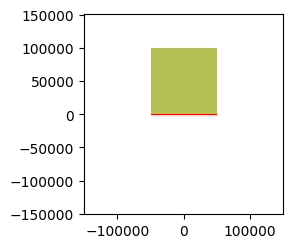

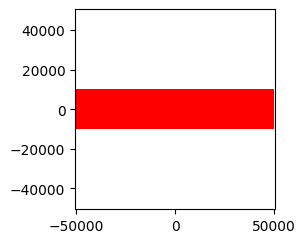

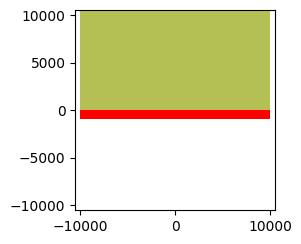

In [18]:
#ground surface
air_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -10000, 10000, 0, 100000)
air_cell = openmc.Cell(region=-air_surface, fill=air)

ground_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -10000, 10000, -1000, 0)
ground_cell = openmc.Cell(region=-ground_surface, fill=ground_material)

xmin = openmc.XPlane(x0=-50001, boundary_type = 'vacuum')
xmax = openmc.XPlane(x0=50001, boundary_type = 'vacuum')
ymin = openmc.YPlane(y0=-10001, boundary_type = 'vacuum')
ymax = openmc.YPlane(y0=10001, boundary_type = 'vacuum')
zmin = openmc.ZPlane(z0=-1001, boundary_type = 'vacuum')
zmax = openmc.ZPlane(z0=100001, boundary_type = 'vacuum')

void_region = +xmin & -xmax & -ymax & +ymin & +zmin & -zmax

void_cell =  openmc.Cell(region=void_region)

universe = openmc.Universe(cells=[air_cell, void_cell, ground_cell])
geom = openmc.Geometry(universe)
geom.export_to_xml()

color_assignment = {void_cell: 'blue', ground_cell: 'red', air:'purple'}
plt.show(universe.plot(width=(300100, 301100), basis='xz', colors=color_assignment))
plt.show(universe.plot(width=(101100, 101100), basis='xy', colors=color_assignment))
plt.show(universe.plot(width=(21100, 21100), basis='yz', colors=color_assignment))

In [19]:
#set at 2Mev energy and 45 degree angle while varying soruce height)
def sim_sett(height):
    #create the source
    sett = openmc.Settings()
    sett.particles = 1000000
    sett.batches = 4
    sett.inactive = 0
    sett.run_mode = 'fixed source'

    source = openmc.Source()
    source.particle = 'neutron'
    source.energy = openmc.stats.Discrete([19e6], [1])

    mu = openmc.stats.Uniform(cos(pi/4), 1.0)
    phi = openmc.stats.Uniform(0.0, 2*pi)
    source.angle  = openmc.stats.PolarAzimuthal(mu, phi, reference_uvw=(0, 0., 1))
    source.space = openmc.stats.Point((0,0,height))
    #%matplotlib inline
    #plot = source.plot_source_direction()
    #plot.show()
    sett.source = source
    sett.export_to_xml()
    return sett


In [20]:
#mesh
air_mesh = openmc.RegularMesh(mesh_id=1, name="air_mesh")
air_mesh.dimension = [1000,1,1]
air_mesh.lower_left = [-50000,-10000, 0]

air_mesh.upper_right = [50000,10000, 100]
mesh_filter = openmc.MeshFilter(air_mesh)

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)


In [21]:
#tally
def create_tally():
    tallies = openmc.Tallies()
    shine_tally = openmc.Tally(name='shine_tally')
    neutron_filter = openmc.ParticleFilter(['neutron'])
    shine_tally.scores  = ['flux']
    shine_tally.filters = [mesh_filter, neutron_filter]
    tallies.append(shine_tally)
    tallies.export_to_xml()
    return tallies

In [22]:
source_height = np.array([1000, 2000, 5000, 7500, 10000, 20000, 35000, 50000])
source_height

array([ 1000,  2000,  5000,  7500, 10000, 20000, 35000, 50000])

In [23]:


df_list = []
for height in source_height:
    settings = sim_sett(height)
    sim_tallies = create_tally()
    print(height)
    model = openmc.model.Model(geom, mats, settings, sim_tallies)
    !rm *.h5
    results_filename = model.run()
    
    results = openmc.StatePoint(results_filename)
    flux_tally = results.get_tally(name="shine_tally")
    df = flux_tally.get_pandas_dataframe()
    df_list.append(df)
    results.close()

1000
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 ################

In [24]:
mesh_vol = 10*20
distance_x = air_mesh.vertices[:,0,0,0]
for i, height in enumerate(source_height):
    df_list[i]["Heights"] = height

0.0005935302075269225
0.0004077182987010387
0.00020704688031494652
0.00013623966043236631
9.683064614132176e-05
3.126114446691122e-05
2.7563819601874833e-05
2.9645043525315435e-06


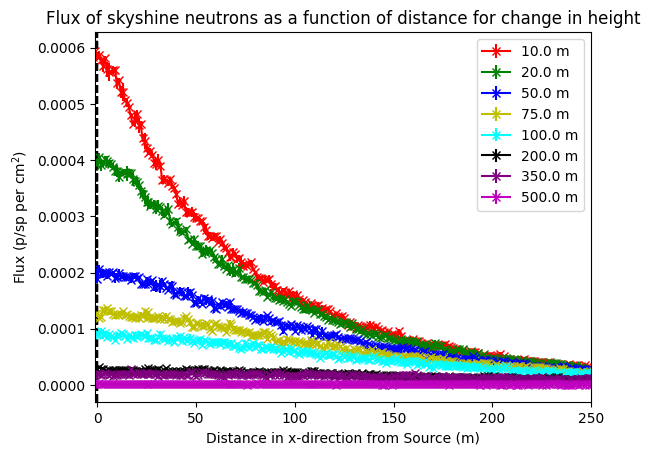

<Figure size 640x480 with 0 Axes>

In [25]:
max_means = []
max_stds = []

for df in df_list[:]:
    
    flux = df[df['score'] == 'flux']
    flux_mean = flux["mean"] / mesh_vol
    flux_std = flux["std. dev."] / mesh_vol
    max_means.append(np.max(flux_mean))
    max_stds.append(flux_std[np.argmax(flux_mean)])

    plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'cyan', 'black', 'purple','m','olive', 'pink', 'lime', 'navy', 'turquoise' ]))) 
    plt.errorbar(distance_x[:-1]/100, flux_mean, flux_std, label=(str(df["Heights"][0]/100)+ " m"), marker='x')
    plt.legend()
    plt.xlabel("Distance in x-direction from Source (m)")
    plt.ylabel("Flux (p/sp per cm$^2$)")
    plt.axvline(x=0, ls='--', color='black')
    plt.xlim(-1, 250)
    plt.title("Flux of skyshine neutrons as a function of distance for change in height")
    #plt.ylim(0,0.02)
    #plt.xscale('log')
    #plt.yscale('log')
    print(np.max(flux_mean))
   
plt.show()
plt.savefig("flux_dist.png")

In [26]:
max_stds

[4.399168638352989e-06,
 8.48617240007829e-06,
 6.452693946374065e-06,
 2.436927950710406e-06,
 4.515614366324134e-06,
 2.583474603915714e-06,
 3.825710354943414e-06,
 7.423266546660575e-07]

array([ 1000,  2000,  5000,  7500, 10000, 20000, 35000, 50000])

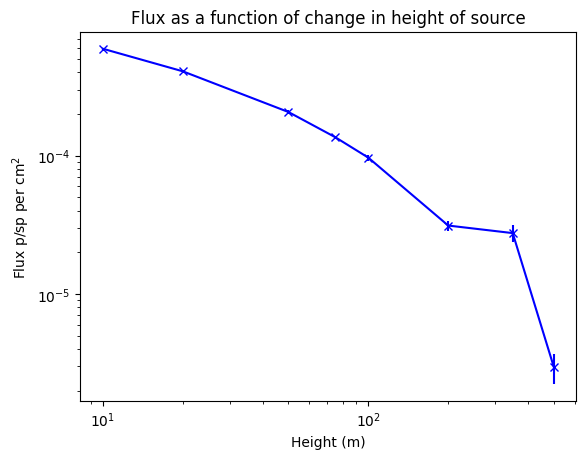

In [27]:
plt.errorbar(source_height/100, max_means, yerr=max_stds, color='b', ls=None, marker='x')
plt.xlabel("Height (m)")
plt.ylabel("Flux p/sp per cm$^2$")
plt.title("Flux as a function of change in height of source")
#plt.ylim(0.0001, 0.5)
plt.xscale('log')
plt.yscale('log')

source_height